# This is a Time Series Analysis Project
## The purpose is to Test the different types of models available to create forecasting models


## Objectives:
#### 1. Deconstruct the Time Series component
- Trend
- Moving Averages
- Cyclical components
- Autoregressive analysis

#### 2. Build & Analyze ARIMA model
#### 3. Build additional models to compare performance
- ETS model
- Random Forests with XGBoost
- RNNs model
- LSTM model
- Prophet model

#### 4. Validate each model
- Train-Test split
- Cross-validation
- Hyper-parameter tuning

#### 5. Print & Analyze the results
- Root Mean Square Error
- Mean Absolute Percentage Error


In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [70]:
import pandas as pd
import numpy as np
from math import sqrt
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='dark')

# For traditional Time Series Models (ARIMA, ETS)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

# For Machine Learning Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

#For RNNs
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM

# For PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable

#Prophet
from prophet import Prophet


## Data Preparation

- convert to the right types
- mark important features as numerical 
- extract date values from the date column
- check for nulls

In [4]:
raw_data = pd.read_csv('RFMdata.csv')
raw_data['Date'] =pd.to_datetime(raw_data['Date'],dayfirst=True)
raw_data['Country'] = np.where(raw_data['Country'] == 'United Kingdom', 1, 0)
raw_data.sort_values(by='Date',inplace=True)


In [5]:
df = raw_data.copy()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1004437 entries, 0 to 1004436
Data columns (total 14 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   InvoiceNo       1004437 non-null  object        
 1   StockCode       1004437 non-null  object        
 2   Description     1004437 non-null  object        
 3   Quantity        1004437 non-null  int64         
 4   Price           1004437 non-null  float64       
 5   CustomerID      1004437 non-null  float64       
 6   Country         1004437 non-null  int32         
 7   Month_Year      1004437 non-null  object        
 8   Total           1004437 non-null  float64       
 9   Date            1004437 non-null  datetime64[ns]
 10  recency         1004437 non-null  int64         
 11  frequency       1004437 non-null  int64         
 12  monetary_value  1004437 non-null  float64       
 13  Cluster         1004437 non-null  int64         
dtypes: datetime64[ns](

In [7]:
df.isnull().sum()

InvoiceNo         0
StockCode         0
Description       0
Quantity          0
Price             0
CustomerID        0
Country           0
Month_Year        0
Total             0
Date              0
recency           0
frequency         0
monetary_value    0
Cluster           0
dtype: int64

In [8]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek  # Monday=0, Sunday=6
df['DayName'] = df['Date'].dt.day_name()
df

,InvoiceNo,StockCode,Description,Quantity,Price,CustomerID,Country,Month_Year,Total,Date,recency,frequency,monetary_value,Cluster,Year,Month,Day,DayOfWeek,DayName
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95,13085.0,1,2009-12,83.40,2009-12-01 07:45:00,158,84,2433.28,0,2009,12,1,1,Tuesday
1,489434,79323P,PINK CHERRY LIGHTS,12,6.75,13085.0,1,2009-12,81.00,2009-12-01 07:45:00,158,84,2433.28,0,2009,12,1,1,Tuesday
2,489434,79323W,WHITE CHERRY LIGHTS,12,6.75,13085.0,1,2009-12,81.00,2009-12-01 07:45:00,158,84,2433.28,0,2009,12,1,1,Tuesday
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2.10,13085.0,1,2009-12,100.80,2009-12-01 07:45:00,158,84,2433.28,0,2009,12,1,1,Tuesday
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.25,13085.0,1,2009-12,30.00,2009-12-01 07:45:00,158,84,2433.28,0,2009,12,1,1,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004424,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,12680.0,0,2011-12,16.60,2011-12-09 12:50:00,1,49,790.81,0,2011,12,9,4,Friday
1004423,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680.0,0,2011-12,10.20,2011-12-09 12:50:00,1,49,790.81,0,2011,12,9,4,Friday
1004435,581587,22730,ALARM CLOCK BAKELIKE IVORY,4,3.75,12680.0,0,2011-12,15.00,2011-12-09 12:50:00,1,49,790.81,0,2011,12,9,4,Friday
1004428,581587,22631,CIRCUS PARADE LUNCH BOX,12,1.95,12680.0,0,2011-12,23.40,2011-12-09 12:50:00,1,49,790.81,0,2011,12,9,4,Friday


### 1. Time Series EDA
#### we want to test the data for the following components:
- Trend
- Stationarity
- Autocorrolation
- Decomposition of TSA components

In [9]:
list1 = ['Price','Quantity','Total']
country_map = {0: 'Outside UK', 1 : 'UK'}
colour_map = {0: 'orange', 1 : 'teal'}

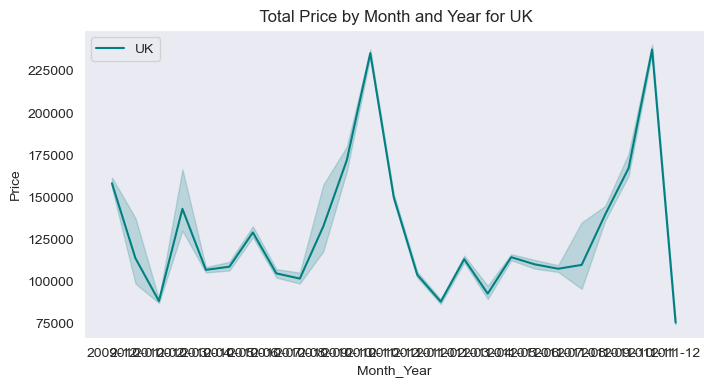

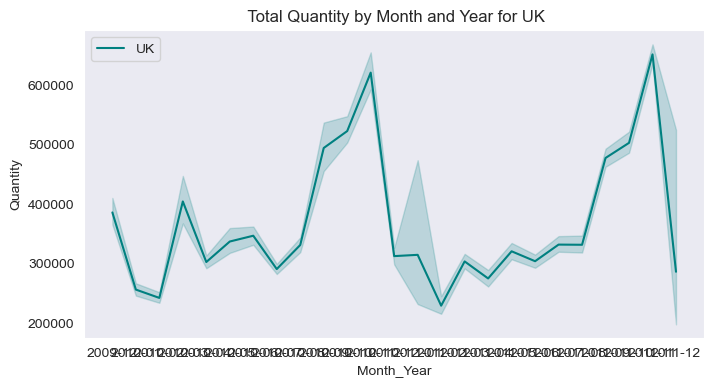

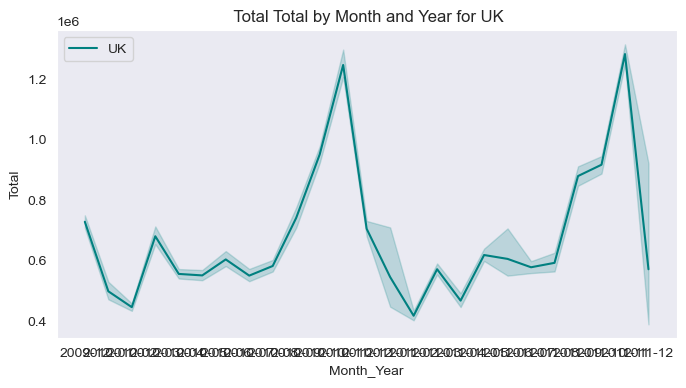

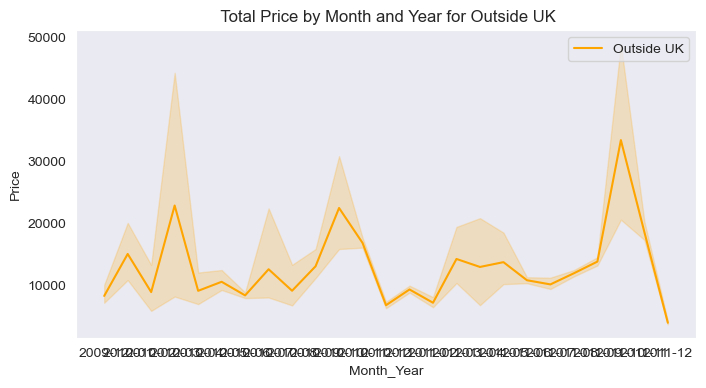

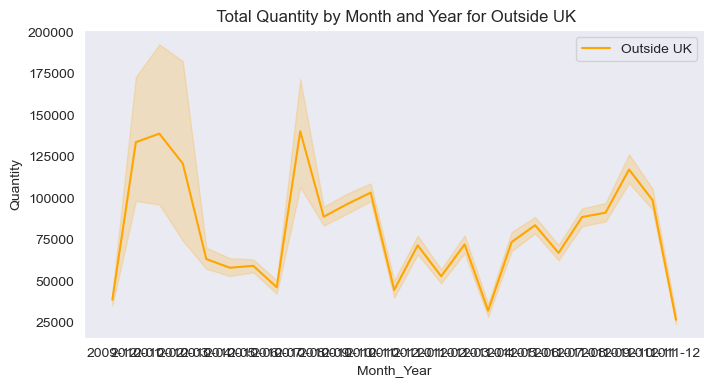

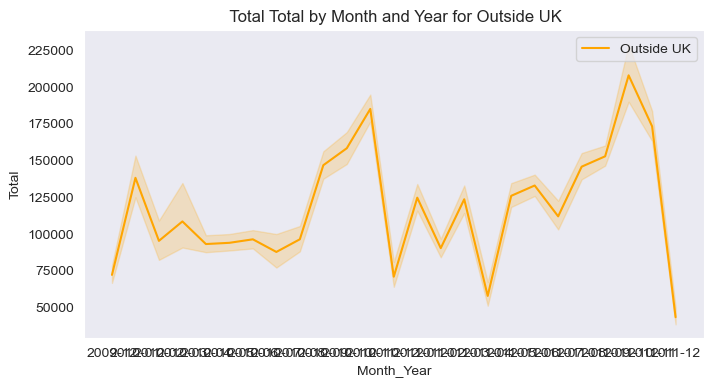

In [10]:
for country_code in raw_data['Country'].unique():
    country_data = raw_data[raw_data['Country'] == country_code]
    for i in list1:
        plt.figure(figsize=(8, 4))
        sns.lineplot(data=country_data, x='Month_Year', y=i, estimator='sum', label=country_map[country_code], color=colour_map[country_code])
        plt.xlabel('Month_Year')
        plt.ylabel(i)
        plt.title(f' Total {i} by Month and Year for {country_map[country_code]}')
        plt.legend()
        plt.show()

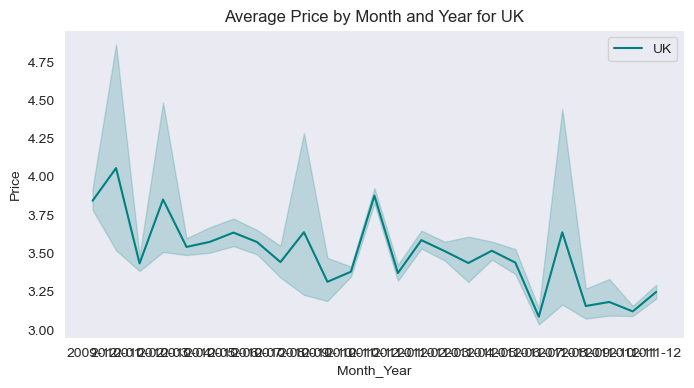

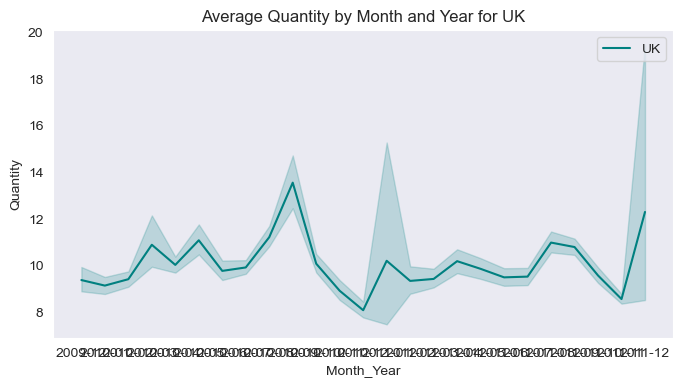

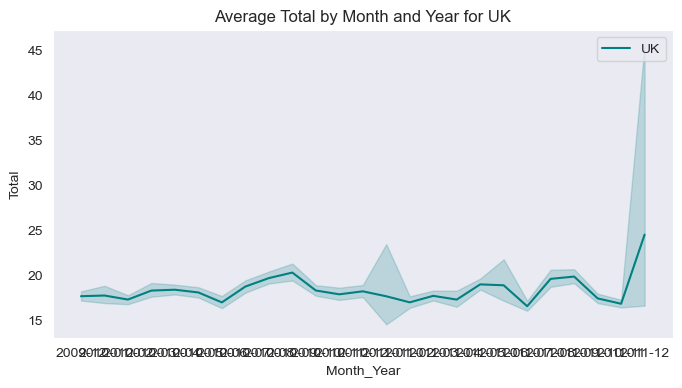

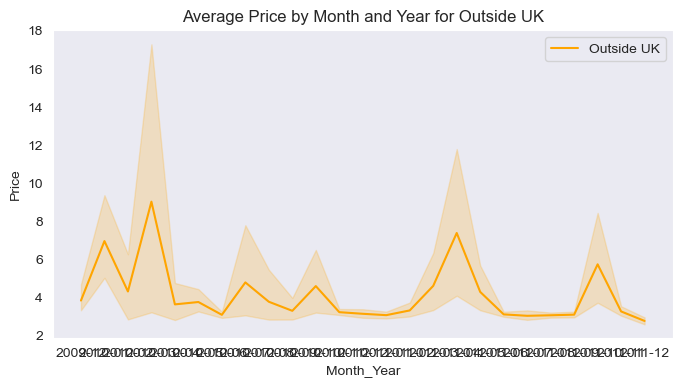

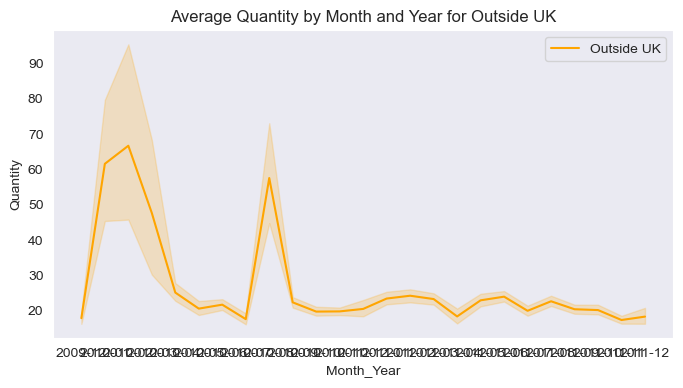

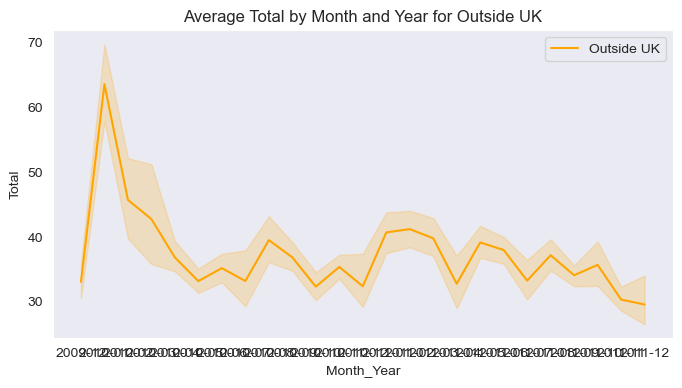

In [11]:
for country_code in raw_data['Country'].unique():
    country_data = raw_data[raw_data['Country'] == country_code]
    for i in list1:
        plt.figure(figsize=(8, 4))
        sns.lineplot(data=country_data, x='Month_Year', y=i, estimator='mean', label=country_map[country_code], color=colour_map[country_code])
        plt.xlabel('Month_Year')
        plt.ylabel(i)
        plt.title(f'Average {i} by Month and Year for {country_map[country_code]}')
        plt.legend()
        plt.show()

In [12]:
monthly_df = pd.DataFrame(df.groupby('Month_Year')['Total'].sum())
monthly_df

,Total
Month_Year,
2009-12,800938.470
2010-01,637124.602
2010-02,541819.026
2010-03,789429.731
2010-04,649489.502
2010-05,645401.900
2010-06,700620.350
2010-07,638532.130
2010-08,678965.440


we want to analyze the moving averages

In [13]:
rolling_mean3 = monthly_df.rolling(3).mean()
rolling_std3 = monthly_df.rolling(3).std()
rolling_mean6 = monthly_df.rolling(6).mean()
rolling_std6 = monthly_df.rolling(6).std()

In [14]:
rolling_mean6

,Total
Month_Year,
2009-12,NaN
2010-01,NaN
2010-02,NaN
2010-03,NaN
2010-04,NaN
2010-05,677367.205167
2010-06,660647.518500
2010-07,660882.106500
2010-08,683739.842167


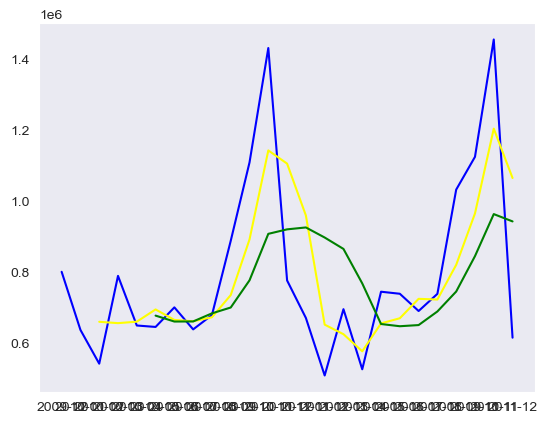

In [15]:
plt.plot(monthly_df, color="blue",label="Original Sales Data")
plt.plot(rolling_mean3, color="yellow", label="Rolling Mean Passenger Number")
plt.plot(rolling_mean6, color="green", label="Rolling Mean Passenger Number")


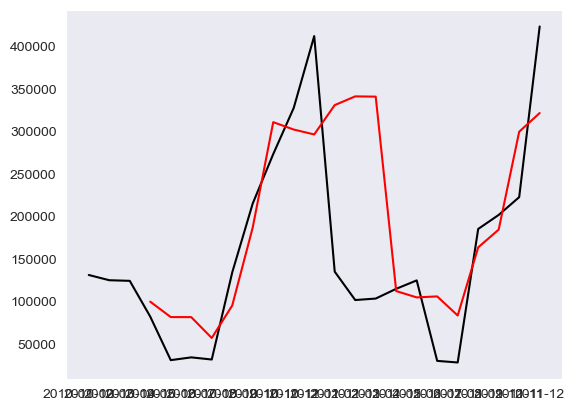

In [16]:
plt.plot(rolling_std3, color="black", label = "Rolling Standard Deviation in Passenger Number")
plt.plot(rolling_std6, color="red", label = "Rolling Standard Deviation in Passenger Number")

In [17]:
adft = adfuller(monthly_df,autolag="AIC")
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

      Values                       Metric
0  -3.382154              Test Statistics
1   0.011582                      p-value
2   9.000000             No. of lags used
3  15.000000  Number of observations used
4  -3.964443          critical value (1%)
5  -3.084908          critical value (5%)
6  -2.681814         critical value (10%)


In [18]:
daily_df = df.groupby([df['Date'].dt.date])[['Quantity','Price','Total']].sum()
daily_df

,Quantity,Price,Total
Date,,,
2009-12-01,26070,12165.77,52438.61
2009-12-02,31799,11826.26,61873.10
2009-12-03,49220,10228.32,73109.78
2009-12-04,21194,8412.61,39350.27
2009-12-05,5119,1443.26,9803.05
...,...,...,...
2011-12-05,44477,18432.56,80481.58
2011-12-06,30351,8903.78,55263.16
2011-12-07,41766,6491.22,72799.09


In [19]:
daily_df['Total']

Date
2009-12-01     52438.61
2009-12-02     61873.10
2009-12-03     73109.78
2009-12-04     39350.27
2009-12-05      9803.05
                ...    
2011-12-05     80481.58
2011-12-06     55263.16
2011-12-07     72799.09
2011-12-08     77572.45
2011-12-09    198094.64
Name: Total, Length: 604, dtype: float64

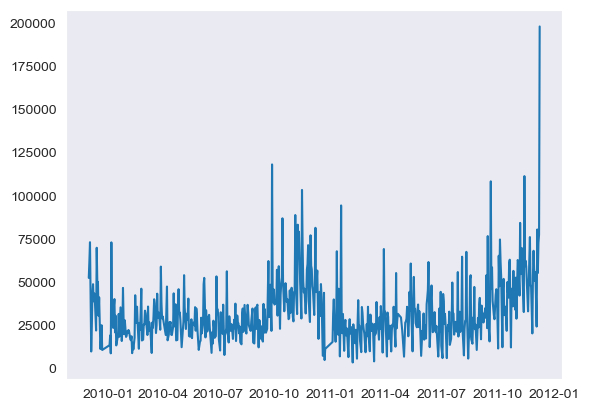

In [20]:
plt.plot(daily_df['Total'])

In [21]:
# ADF Test for Quantity
result_quantity = adfuller(daily_df['Quantity'])
print('ADF Statistic for Quantity:', result_quantity[0])
print('p-value for Quantity:', result_quantity[1])
print('Critical Values for Quantity:')
for key, value in result_quantity[4].items():
    print(f'{key}: {value}')

# ADF Test for Price
result_price = adfuller(daily_df['Price'])
print('\nADF Statistic for Price:', result_price[0])
print('p-value for Price:', result_price[1])
print('Critical Values for Price:')
for key, value in result_price[4].items():
    print(f'{key}: {value}')

# ADF Test for Total
result_total = adfuller(daily_df['Total'])
print('\nADF Statistic for Total:', result_total[0])
print('p-value for Total:', result_total[1])
print('Critical Values for Total:')
for key, value in result_total[4].items():
    print(f'{key}: {value}')

ADF Statistic for Quantity: -2.875368917019264
p-value for Quantity: 0.04828814606468122
Critical Values for Quantity:
1%: -3.441444394224128
5%: -2.8664345376276454
10%: -2.569376663737217

ADF Statistic for Price: -2.3106738523767567
p-value for Price: 0.1685485479321011
Critical Values for Price:
1%: -3.441444394224128
5%: -2.8664345376276454
10%: -2.569376663737217

ADF Statistic for Total: -0.566246213482289
p-value for Total: 0.8784280678396289
Critical Values for Total:
1%: -3.4415584920942424
5%: -2.866484781324317
10%: -2.569403436033035


In [22]:
autocorrelation_lag1 = monthly_df['Total'].autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)
autocorrelation_lag3 = monthly_df['Total'].autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = monthly_df['Total'].autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = monthly_df['Total'].autocorr(lag=9)
print("Nine Month Lag: ", autocorrelation_lag9)

One Month Lag:  0.39915379767377973
Three Month Lag:  -0.2455383807819334
Six Month Lag:  -0.21746253632336596
Nine Month Lag:  -0.3468276237163966


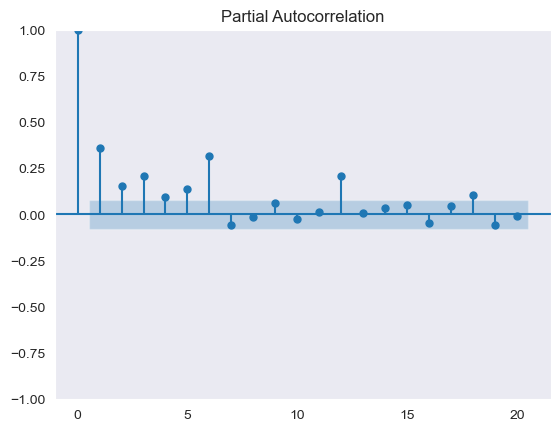

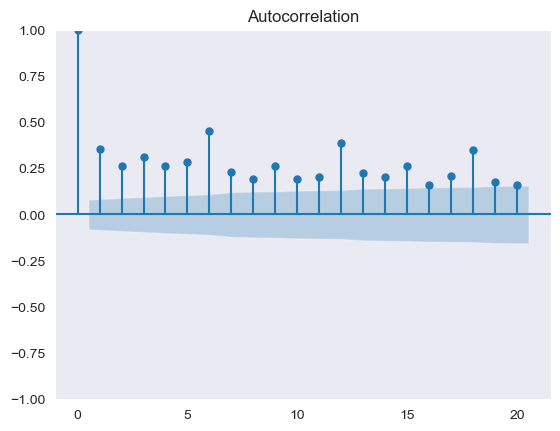

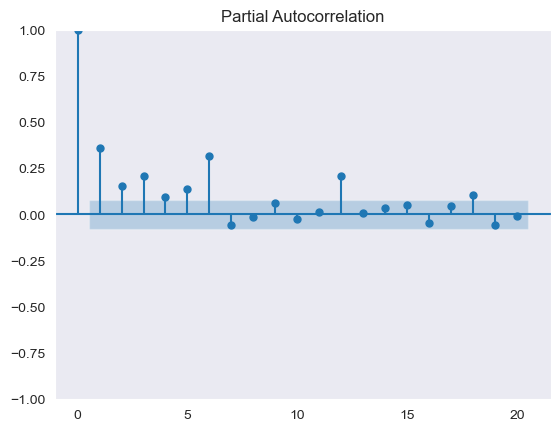

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
lags = 20
plot_acf(daily_df['Total'], lags=lags)
plot_pacf(daily_df['Total'], lags=lags)


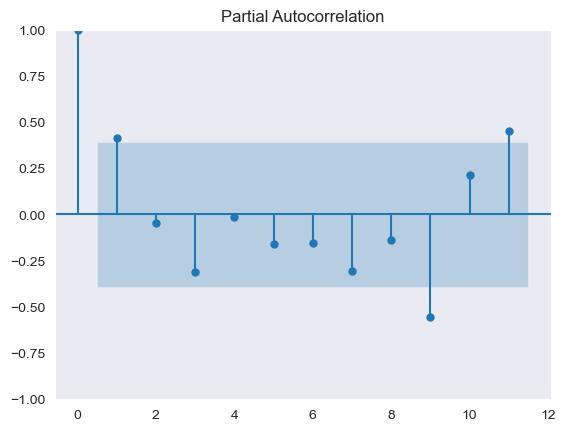

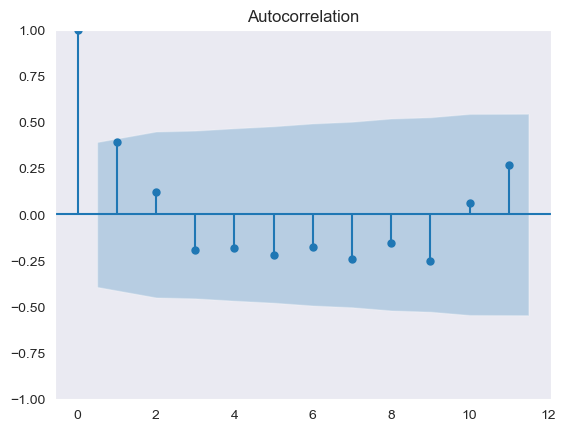

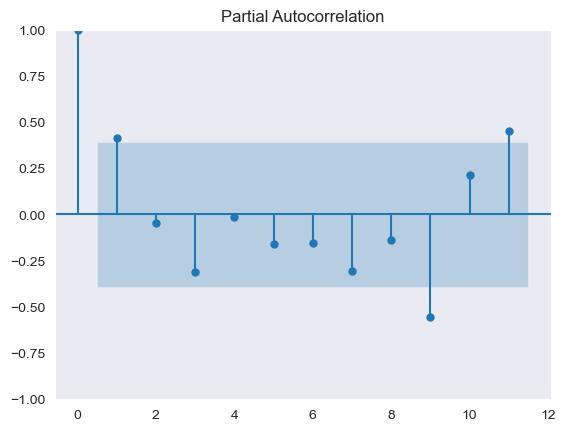

In [24]:
lags = 11
plot_acf(monthly_df, lags=lags)
plot_pacf(monthly_df, lags=lags)

In [25]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lags = 20  # Number of lags to test
lb_test = acorr_ljungbox(daily_df['Total'], lags=lags)
print("Ljung-Box Test p-values: ", lb_test.iloc[:,1])


Ljung-Box Test p-values:  1      1.473322e-18
2      1.353374e-26
3      1.949344e-38
4      2.244336e-46
5      5.004818e-56
6      1.106149e-81
7      9.201112e-88
8      1.222031e-91
9     6.996639e-100
10    9.301493e-104
11    3.220891e-108
12    7.504951e-127
13    1.372135e-132
14    3.527640e-137
15    1.841693e-145
16    4.474706e-148
17    6.323936e-153
18    4.886991e-168
19    2.231813e-171
20    5.042775e-174
Name: lb_pvalue, dtype: float64


In [26]:
lags = 11  # Number of lags to test
lb_test = acorr_ljungbox(monthly_df, lags=lags)
print("Ljung-Box Test p-values: ", lb_test.iloc[:,1])

Ljung-Box Test p-values:  1     0.036298
2     0.090030
3     0.113170
4     0.133480
5     0.123165
6     0.136144
7     0.103673
8     0.117902
9     0.078893
10    0.110840
11    0.059075
Name: lb_pvalue, dtype: float64


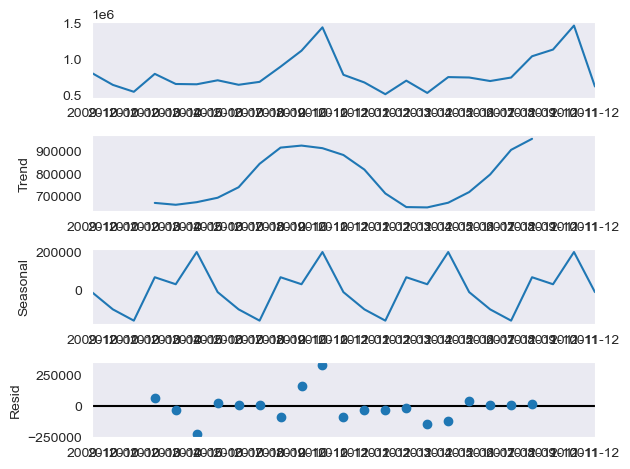

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(monthly_df,model='additive', period=6)
decompose.plot()
plt.show()

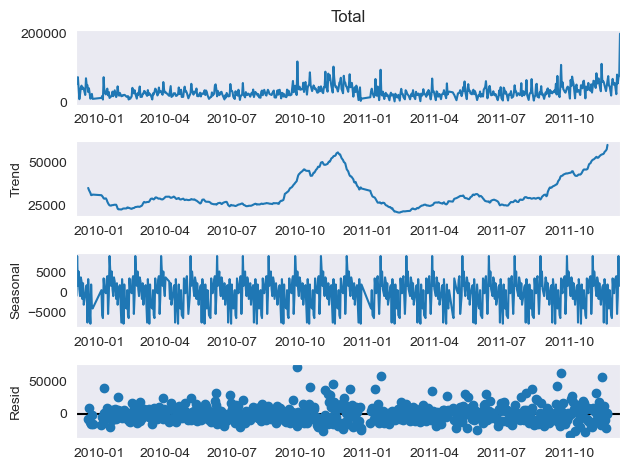

In [28]:
decompose = seasonal_decompose(daily_df['Total'],model='additive', period=30)
decompose.plot()
plt.show()

In [29]:
# Function to calculate MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [30]:
monthly_df

,Total
Month_Year,
2009-12,800938.470
2010-01,637124.602
2010-02,541819.026
2010-03,789429.731
2010-04,649489.502
2010-05,645401.900
2010-06,700620.350
2010-07,638532.130
2010-08,678965.440


In [38]:
tscv = TimeSeriesSplit(n_splits=6,test_size=3)
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=6, test_size=3)


In [92]:
tscv = TimeSeriesSplit(n_splits=6, test_size=3)
order = (1, 0, 3)  # Define the order of the ARIMA model (replace p, d, q with appropriate values)
predictions_arima = []
monthly_df['predictions'] = 0

for i, (train_index, test_index) in enumerate(tscv.split(monthly_df)):
    train_data = monthly_df['Total'][train_index].values
    test_data = monthly_df['Total'][test_index].values
    
    # Fit ARIMA model
    arima_model = ARIMA(train_data, order=order)
    arima_model_fit = arima_model.fit(transformed=False, method='statespace')
    
    # Make predictions for the specific test fold size
    predictions = arima_model_fit.forecast(steps=len(test_index))
    
    print("Length of test_index:", len(test_index))
    print("Length of predictions:", len(predictions))
    
    # Extend predictions and assign to the appropriate indices in the dataframe
    predictions_arima.extend(predictions)
    monthly_df['predictions'][test_index] = predictions

# Calculate MAPE and RMSE
mape_arima = calculate_mape(monthly_df['Total'][-len(predictions_arima):], predictions_arima)
rmse_arima = np.sqrt(mean_squared_error(monthly_df['Total'][-len(predictions_arima):], predictions_arima))

print("ARIMA Model MAPE: {:.2f}%".format(mape_arima))
print("ARIMA Model RMSE: {:.2f}".format(rmse_arima))


Length of test_index: 3
Length of predictions: 3
Length of test_index: 3
Length of predictions: 3
Length of test_index: 3
Length of predictions: 3


c:\Users\27722\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\27722\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Length of test_index: 3
Length of predictions: 3
Length of test_index: 3
Length of predictions: 3
Length of test_index: 3
Length of predictions: 3
ARIMA Model MAPE: 25.11%
ARIMA Model RMSE: 333799.41


c:\Users\27722\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\27722\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [94]:
tscv = TimeSeriesSplit(n_splits=12, test_size=30)
order = (1, 2, 6)  # Define the order of the ARIMA model (replace p, d, q with appropriate values)
predictions_arima = []
daily_df['predictions'] = 0

for i, (train_index, test_index) in enumerate(tscv.split(daily_df)):
    train_data = daily_df['Total'][train_index].values
    test_data = daily_df['Total'][test_index].values
    
    # Fit ARIMA model
    arima_model = ARIMA(train_data, order=order)
    arima_model_fit = arima_model.fit(transformed=False, method='statespace')
    
    # Make predictions for the specific test fold size
    predictions = arima_model_fit.forecast(steps=len(test_index))
    
    print("Length of test_index:", len(test_index))
    print("Length of predictions:", len(predictions))
    
    # Extend predictions and assign to the appropriate indices in the dataframe
    predictions_arima.extend(predictions)
    daily_df['predictions'][test_index] = predictions

# Calculate MAPE and RMSE
mape_arima = calculate_mape(daily_df['Total'][-len(predictions_arima):], predictions_arima)
rmse_arima = np.sqrt(mean_squared_error(daily_df['Total'][-len(predictions_arima):], predictions_arima))

print("ARIMA Model MAPE: {:.2f}%".format(mape_arima))
print("ARIMA Model RMSE: {:.2f}".format(rmse_arima))

Length of test_index: 30
Length of predictions: 30
Length of test_index: 30
Length of predictions: 30


c:\Users\27722\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Length of test_index: 30
Length of predictions: 30


c:\Users\27722\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Length of test_index: 30
Length of predictions: 30
Length of test_index: 30
Length of predictions: 30
Length of test_index: 30
Length of predictions: 30
Length of test_index: 30
Length of predictions: 30
Length of test_index: 30
Length of predictions: 30


c:\Users\27722\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Length of test_index: 30
Length of predictions: 30


c:\Users\27722\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Length of test_index: 30
Length of predictions: 30
Length of test_index: 30
Length of predictions: 30
Length of test_index: 30
Length of predictions: 30
ARIMA Model MAPE: 65.34%
ARIMA Model RMSE: 20651.55


In [106]:
tscv = TimeSeriesSplit(n_splits=6, test_size=3)
order = (1, 0, 3)  # Define the order of the ARIMA model (replace p, d, q with appropriate values)
seasonal_order =(1,0,9,12)
predictions_sarima = []
monthly_df['predictions'] = 0

for i, (train_index, test_index) in enumerate(tscv.split(monthly_df)):
    train_data = monthly_df['Total'][train_index].values
    test_data = monthly_df['Total'][test_index].values
    
    # Fit SARIMA model
    sarima_model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
    sarima_model_fit = sarima_model.fit()
    
    # Make predictions
    predictions = sarima_model_fit.forecast(steps=len(test_data))
    
    # Extend predictions and assign to the appropriate indices in the dataframe
    predictions_sarima.extend(predictions)
    monthly_df['predictions'][test_index] = predictions

# Slice predictions array to match the length of the test data
predictions_sarima = predictions_sarima[:len(monthly_df['Total'])]

# Calculate MAPE and RMSE
mape_sarima = calculate_mape(monthly_df['Total'][-len(predictions_sarima):], predictions_sarima)
rmse_sarima = np.sqrt(mean_squared_error(monthly_df['Total'][-len(predictions_sarima):], predictions_sarima))

print("SARIMA Model MAPE: {:.2f}%".format(mape_sarima))
print("SARIMA Model RMSE: {:.2f}".format(rmse_sarima))


c:\Users\27722\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\27722\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\27722\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\27722\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\27722\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

SARIMA Model MAPE: 14.69%
SARIMA Model RMSE: 229956.92


#### We now run a fit on the whole data and test from there and make 3, 6 & 12 months predictions

In [107]:
monthly_df

,Total,predictions
Month_Year,,
2009-12,800938.470,0.000000e+00
2010-01,637124.602,0.000000e+00
2010-02,541819.026,0.000000e+00
2010-03,789429.731,0.000000e+00
2010-04,649489.502,0.000000e+00
2010-05,645401.900,0.000000e+00
2010-06,700620.350,0.000000e+00
2010-07,638532.130,6.625373e+05
2010-08,678965.440,6.625204e+05


We can run more test to tune the hyperparameters
we need to test other models before committing to fine tuning one


<Axes: >

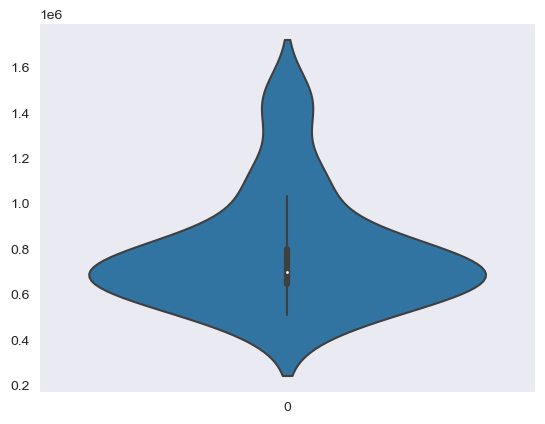

In [108]:
sns.violinplot(monthly_df['Total'])

<Axes: >

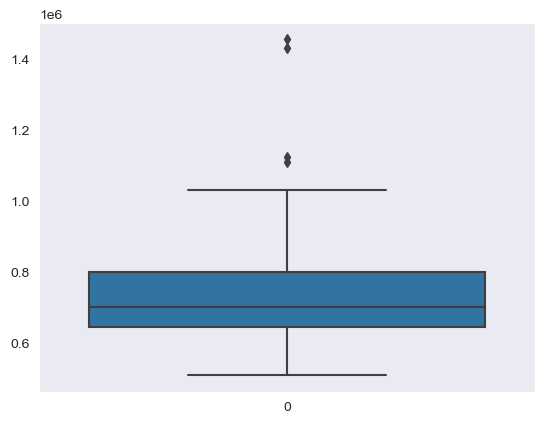

In [109]:
sns.boxplot(monthly_df['Total'])

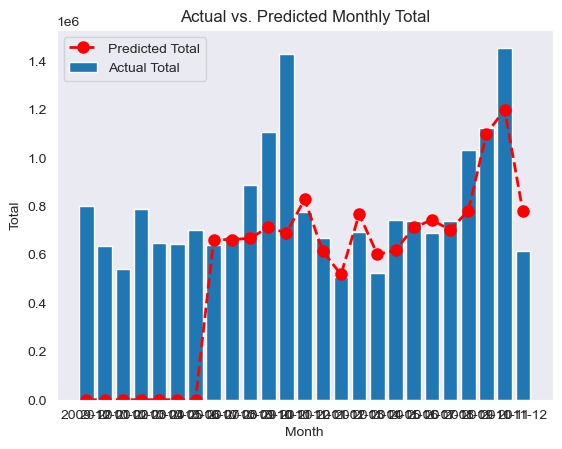

In [112]:
plt.bar(monthly_df.index, monthly_df['Total'], label='Actual Total')

# Overlaying the line chart for predictions
plt.plot(monthly_df ['predictions'], color='red', marker='o', linestyle='dashed', linewidth=2, markersize=8, label='Predicted Total')

# Adding labels and title
plt.xlabel('Month')
plt.ylabel('Total')
plt.title('Actual vs. Predicted Monthly Total')
#plt.xticks(monthly_df.index, ['Jan', 'Feb', 'Mar', 'Apr', 'May'])  # Assuming the index represents months

# Adding legend
plt.legend()

# Display the plot
plt.show()

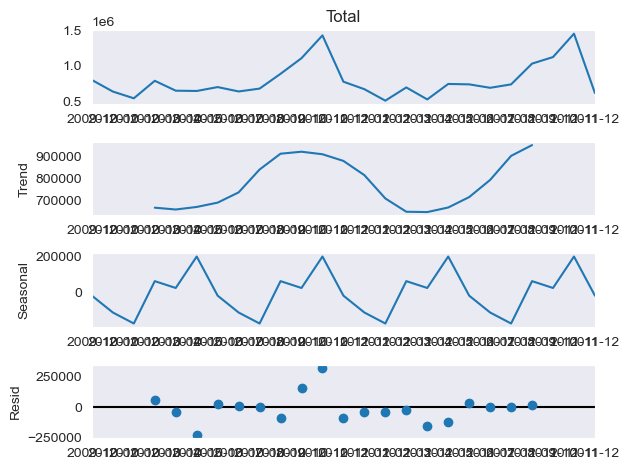

In [114]:
decompose = seasonal_decompose(monthly_df['Total'],model='additive', period=6)
decompose.plot()
plt.show()

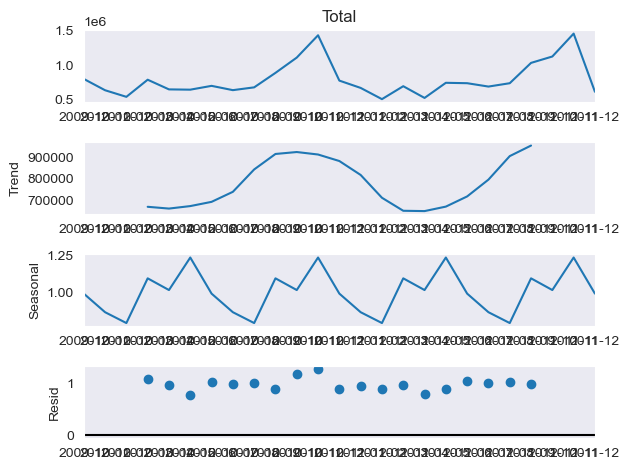

In [113]:
decompose = seasonal_decompose(monthly_df['Total'],model='multiplicative', period=6)
decompose.plot()
plt.show()